# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
data['income'].unique()

array(['<=50K', '>50K'], dtype=object)

In [3]:
# Total number of records
n_records = len(data.index)

# Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data['income'] == ">50K"].index)

# Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data['income'] == "<=50K"].index)

# Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k / n_records

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 0.2478439697492371%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

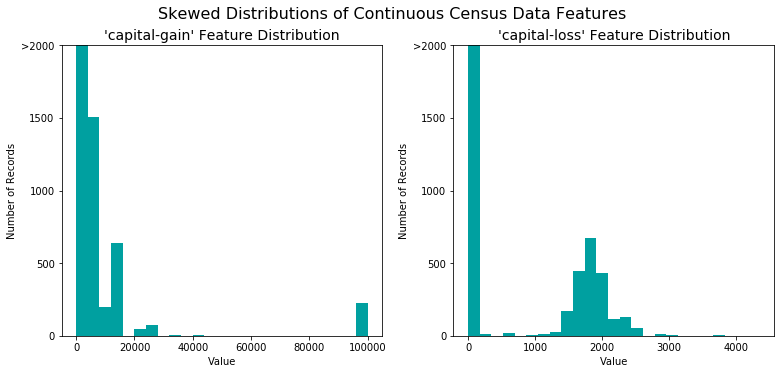

In [4]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

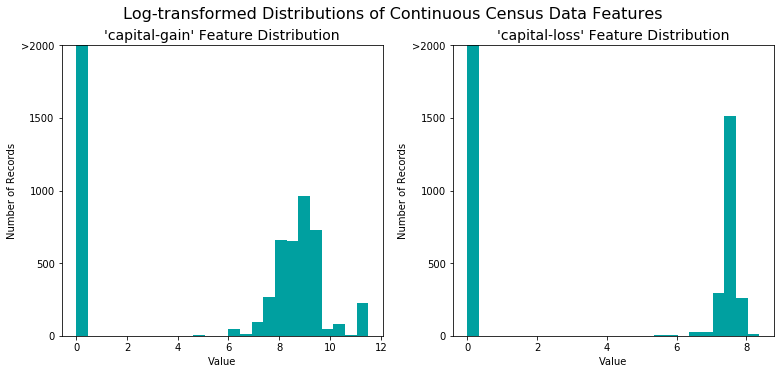

In [5]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [6]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

/Users/kyle.b/code/src/github.com/KyleBanks/udacity-ml-engineer-nanodegree/env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [7]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw == '>50K'

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
# print(encoded)

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [8]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [9]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
TP = np.sum(income)
FP = income.count() - TP
TN = 0
FN = 0

# Calculate accuracy, precision and recall
accuracy = TP / (TP + FP)
recall = TP / (TP + FN)
precision = TP / (TP + FP)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
𝛽 = 0.5
fscore = (1 + np.square(𝛽)) * ((precision*recall) / (np.square(𝛽) * precision + recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

** HINT: **

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.

**Answer:**

The three models I selected were *Decision Trees*, *Support Vector Machines* and *Ensemble Methods*. My reasoning for these selections are detailed below, along with references to the articles and papers that were instrumental in my research.

**Decision Trees:**

Decision Trees are a simplistic but useful starting model for both classification and regression problems, and are widely used as a first attempt model as they offer several advantages over other models that would make them desirable for production use if possible.

- Many companies use decision trees to mine their existing customer data to make simple binary decisions such as "would existing customer X be interested in new product Y", and if so, send them a marketing blast via email or mobile notification.

- Decision trees offer great benefit in discovering feature importance as the model can be simply deconstructed to view its structure. This allows you to see how it considered each feature at each node, and how it came to each decision it made. You can also get a good idea of how your features correlate with your target label by viewing the top nodes in the tree as they are generally the most predictive. Decision trees are also quite performant both to construct and to make predictions, due to their simplistic structure. 

- Decision trees can suffer significantly from overfitting when they're allowed to create many nodes with small numbers of samples contained within them. In these cases, decision trees will happily memorize your data, but they'll fail to generalize to new cases as they'll effectively turn into a 'nearest neighbors' classifier by finding the training samples that exactly match the features to be predicted, if any. This can be solved via parameter tuning, such as limiting depth/node count or increasing the minimum number of samples required per node. 

- For the problem were looking at here, I feel a decision tree will be well suited to finding the top handful of features that correlate well with incomes >50K. Even if the decision tree doesn't perform as well as the other models I'll be looking at, I feel that by deconstructing and analyzing the decision tree it could prove invaluable in discovering feature correlations that I may not have originally thought of. A decision tree is also a good 'next step' after the naive model as it is likely the most simple learned model we can make that hopefully improves upon the performance of the naive model.

**Support Vector Machines:**

Support Vector Machines (SVM) are a highly versatile algorithm that can be used for binary classification and regression tasks, and offers two primary modes consisting of *hard-margin* and *soft-margin*, which allows you to handle both seperable and non-seperable datasets.

- SVM models have long been used for various tasks in the field of biology, such as for the classification of proteins and brain images. See reference numbers 15 and 16 for more details.

- SVM models offer a number of variations (via kernels, hyperparameters, margin types) that allow them to be used in a variety of situations. SVM is well suited for binary classification of seperable data using a hard-margin, or non-seperable data using a soft-margin approach. Kernel tricks allow you to efficiently handle many nonlinear datasets by modifying your data in such as way as to create a seperable plane between classes. SVM also supports multiple regularization parameters, namely C and gamma, which can be used to regularize the model and prevent overfitting. Finally, SVM tends to excel at properly weighting the most predictive features and zeroing-out the remainders.

- SVM does have its drawbacks though, such as difficulty in tuning C and gamma to strike a balance between under- and overfitting. Some kernel methods are computationally expensive to perform, and may also lead to overfitting. Finally, the parameters and kernels used in your model can easily become difficult to reason about, leading the model acting as a sort of 'black box' that becomes difficult to understand or visualize.

- SVM offers a wide toolbox of tricks and parameters to be used successfully for many problems. Prior to the creation of deep learning and neural nets, SVM was widely considered the top all-around general purpose algorithm for machine learning. For our case specifically, I suspect that the features of our dataset will be seperable in such a way as to make SVM quite successful in predicting individuals with an income of >50K. SVM should be able to maximize the impact of the most predictive features, and zero-out the weights of features that tend to be unimportant or noise.

**Ensemble Methods (AdaBoost):**

Ensemble Methods are an interesting model as they almost allow you to utilize the best features of a particular model type (or even different models) by combining them into a larger system. More specifically, I'll be talking about the AdaBoost ensemble method used with underlying decision trees.

- Ensemble methods, and specifically AdaBoost, are widely used in the industry to 'boost' the performance of various other model types. It is quite difficult to find concrete examples of their use in the real world because most companies or scientists would say they're using the underlying model type(s) rather than saying they're using AdaBoost. For example, I might say I'm using a decision tree model when in fact I'm using various decision trees with AdaBoost. Nevertheless, I did find an example of AdaBoost being used to improve the performance of ~2500 underlying models to predict Foehn wind patterns in the European Alps by the Institute for Atmospheric and Climate Science (see footnote 19). 

- By fitting many shallow decision trees together into a larger ensemble you end up focusing on the more generalizable feature traits that lead to successful predictions, rather than one deep decision tree which tends to simply memorize the training set and overfit. AdaBoost also helps to focus on the more difficult cases by penalizing the model more heavily for incorrectly predicting these difficult samples during training, leading to a more robust model.

- One drawback or criticism of AdaBoost is that it can be seen as a brute-force solution, where you just keep adding more underlying models until to handle every case. In general, ensemble methods by their very definition add complexity to your model as you're no longer using a single model but instead a collection of many. This may also reduce performance, increase training time, and make it difficult to run in streaming or real-time environments. An interesting complexity of using AdaBoost with decision trees (or any underlying model, really) is how to determine how 'weak' your learners should be? If you your decision trees are too weak, then they don't end up being trustworthy enough, but if they're too strong then you end up overfitting.

- My interest in using an ensemble method, specifically AdaBoost with Decision Trees, can be summed up with the benefits of Decision Trees but without many of the drawbacks: specifically, their limited sophistication and tendency to overfit. I suspect that we're going to find only a few truly predictive features in our training set that apply to a majority of the cases, and then the remaining cases will be various combinations of other (less intuitive) features that lead to successful predictions. By using an ensemble method, I hope to gain the simplicity of decision trees in handling the majority of cases, but the sophistication of AdaBoost to learn the remaining difficult cases. 


**Bonus: K-Nearest Neighbors:**

Originally I had K-Nearest Neighbors in my list of models to evaluate, but after doing some research I determined that it wouldn't end up being sufficiently different from a decision tree in this case, and I removed it. My research led to the following negatives which changed my mind: 

> KNN does have a number of drawbacks, namely that it suffers from being computationally expensive on large data sets as the model needs to keep all training data for prediction time. While training will be quite fast, predictions will generally be slow and expensive to perform. Another drawback of KNN is that it is quite difficult to determine the proper value for 'k' and how to measure similarity between neighbors. This causes the algorithm to be sensitive to unimportant or noisy features as they can end up overweighting important features when similarity is measured. Finally, KNN doesn't perform well with categorical features as it is very difficult for it to learn similarities between two categories. For instance, in our case it would be reasonable to assume that employment with the federal or state government is more similar than employment with the federal government and being self-employed. This is easy for us to reason about as humans, but a KNN algorithm has difficulty with these kinds of situations. 


*References:*
1. [Quora: What are the advantages of using a decision tree for classification?](https://www.quora.com/What-are-the-advantages-of-using-a-decision-tree-for-classification)
2. [Towards Data Science: Decision Trees in Machine Learning](https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052)
3. [Edwin Chen: Choosing a Machine Learning Classifier](http://blog.echen.me/2011/04/27/choosing-a-machine-learning-classifier/)
4. [DZone: When to Use Linear Regression, Clustering, or Decision Trees](https://dzone.com/articles/decision-trees-vs-clustering-algorithms-vs-linear)
5. [NCBI: Decision tree methods: applications for classification
and prediction](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4466856/pdf/sap-27-02-130.pdf)
6. [Adi Bronshtein: A Quick Introduction to K-Nearest Neighbors Algorithm](https://medium.com/@adi.bronshtein/a-quick-introduction-to-k-nearest-neighbors-algorithm-62214cea29c7)
7. [MathWorks: Support Vector Machines for Binary Classification](https://www.mathworks.com/help/stats/support-vector-machines-for-binary-classification.html)
8. [statsoft.com: Support Vector Machines (SVM) Introductory Overview](http://www.statsoft.com/textbook/support-vector-machines)
9. [Dikran Marsupial: Advantages and disadvantages of SVM](https://stats.stackexchange.com/a/24440)
10. [Data-Flair: Real-Life Applications of SVM](https://data-flair.training/blogs/applications-of-svm/)
11. [GregL on Alteryx: Why use SVM?](https://community.alteryx.com/t5/Data-Science-Blog/Why-use-SVM/ba-p/138440)
12. [Alexander Statnikov, Douglas Hardin, Isabelle Guyon, Constantin F. Aliferis, New York University, Vanderbilt University, ClopiNet: A Gentle Introduction to Support Vector Machines in Biomedicine](https://med.nyu.edu/chibi/sites/default/files/chibi/Final.pdf)
13. [R. Berwick: An Idiots Guide to Support Vector Machines](http://web.mit.edu/6.034/wwwbob/svm-notes-long-08.pdf)
14. [Sheetal Sharma: Real-Life Applications of Support Vector Machines](https://www.datasciencecentral.com/profiles/blogs/real-life-applications-of-support-vector-machines)
15. [Bilwaj Gaonkar and Christos Davatzikos: Analytic estimation of statistical significance maps for support vector machine based multi-variate image analysis and classification](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3767485/)
16. [Spatial regularization of SVM for the detection of diffusion alterations
associated with stroke outcome](http://www.aramislab.fr/perso/colliot/files/media2011_remi_published.pdf)
17. scikit-learn: [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) and [Ensemble Methods](https://scikit-learn.org/stable/modules/ensemble.html#adaboost)
18. [MIT Press: Boosting Foundations Algorithms](https://mitpress.mit.edu/sites/default/files/titles/content/boosting_foundations_algorithms/toc.html#indx-1)
19. [Michael Sprenger: Nowcasting Foehn Wind Events Using the AdaBoost Machine Learning Algorithm](https://journals.ametsoc.org/doi/full/10.1175/WAF-D-16-0208.1)
20. [Jonathan H. Morra, Zhuowen Tu, Liana G. Apostolova, Amity E. Green, Arthur W. Toga, and Paul M. Thompson: Comparison of AdaBoost and Support Vector Machines for Detecting Alzheimer’s Disease through Automated Hippocampal Segmentation](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2805054/)
21. [Eric Emer: BOOSTING
(ADABOOST ALGORITHM)](http://www-math.mit.edu/~rothvoss/18.304.3PM/Presentations/1-Eric-Boosting304FinalRpdf.pdf)

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [10]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test, beta=0.5): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=beta)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=beta)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

DecisionTreeClassifier trained on 361 samples.
DecisionTreeClassifier trained on 3617 samples.
DecisionTreeClassifier trained on 36177 samples.


/Users/kyle.b/code/src/github.com/KyleBanks/udacity-ml-engineer-nanodegree/env/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/kyle.b/code/src/github.com/KyleBanks/udacity-ml-engineer-nanodegree/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/kyle.b/code/src/github.com/KyleBanks/udacity-ml-engineer-nanodegree/env/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoi

SVC trained on 361 samples.
SVC trained on 3617 samples.


/Users/kyle.b/code/src/github.com/KyleBanks/udacity-ml-engineer-nanodegree/env/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


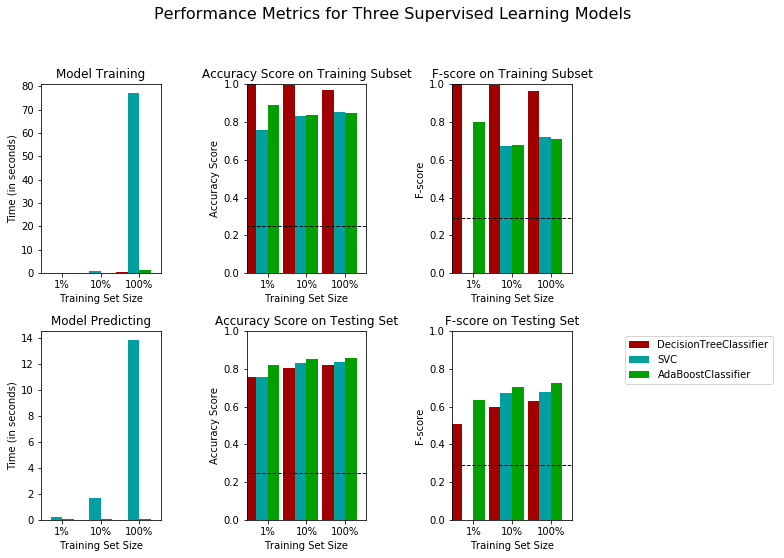

In [11]:
# Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

# Initialize the three models
clf_A = DecisionTreeClassifier(random_state=42)
clf_B = SVC(random_state=42)
clf_C = AdaBoostClassifier(random_state=42)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
# HINT: samples_1 is 1% of samples_100 (ensure to set the count of the values to be `int` and not `float`)
samples_100 = len(y_train)
samples_10 = int(samples_100 * .1)
samples_1 = int(samples_100 * .01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [12]:
results

{'DecisionTreeClassifier': {0: {'train_time': 0.0033342838287353516,
   'pred_time': 0.008925914764404297,
   'acc_train': 1.0,
   'acc_test': 0.755223880597015,
   'f_train': 1.0,
   'f_test': 0.5095226317091269},
  1: {'train_time': 0.02546405792236328,
   'pred_time': 0.008191108703613281,
   'acc_train': 0.9966666666666667,
   'acc_test': 0.8027639579878386,
   'f_train': 0.997191011235955,
   'f_test': 0.5964389088676433},
  2: {'train_time': 0.3736391067504883,
   'pred_time': 0.00664520263671875,
   'acc_train': 0.97,
   'acc_test': 0.8185737976782753,
   'f_train': 0.9638554216867471,
   'f_test': 0.627947840562286}},
 'SVC': {0: {'train_time': 0.011643171310424805,
   'pred_time': 0.20027971267700195,
   'acc_train': 0.76,
   'acc_test': 0.7562189054726368,
   'f_train': 0.0,
   'f_test': 0.0},
  1: {'train_time': 0.8267571926116943,
   'pred_time': 1.6655759811401367,
   'acc_train': 0.8333333333333334,
   'acc_test': 0.8326147042564953,
   'f_train': 0.6712962962962963,
   '

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

** HINT: ** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

**Answer:**

Based on the assessment above, it seems clear that the AdaBoost classifier is the ideal choice for *CharityML*. Not only does it far outperform the SVM classifier in terms of training and prediction time, it outperforms both the SVM and Decision Tree classifiers in terms of accuracy and F-score on test data for every training set size. 

The fact that a boosted Decision Tree would outperform the single Decision Tree is to be expected, as that's the entire purpose of boosting: to improve predictive performance by combining many week learners, thereby reducing bias and overfitting, into a single combined stronger learner. Interstingly, the Decision Tree is the top performer on the training set at all training subset sizes, and the SVM classifier overtakes the AdaBoost classifier when the full training set is used. This indicates that the Decision Tree is consistently overfitting, and that the SVM classifier also overfits given sufficient data with default parameters. The AdaBoost model does a better job of generalizing to the testing data, as shown by its strong outperformance on testing data with all training subset sizes. This will be the critical differentiator when *CharityML* uses the trained model to perform real predictions, as a model that fails to generalize to new samples will never be of great use to them.

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

** HINT: **

When explaining your model, if using external resources please include all citations.

**Answer:** 

An *AdaBoost* classifier is essentially the manifest idea of being greater than the sum of its parts. Basically, AdaBoost makes use of the data set to teach a large number of simplistic models, each of which on its own would be a very poor performer. Each model on its own will each make a single decision such as: *if the person is divorced, predict that they do not make more than $50,000 in income.* Each time one of these simple models is learned, the idea is to see what it and all the preceding models, combined, are still getting wrong. By focusing more on what the ensemble of simple models are failing to predict, future models will be more tailored to those cases. Eventually you wind up with a large collection of weak models, which can then each make predictions as needed. 

At prediction time, each model is then given a chance to 'vote' its opinion on new sample based on what they've learned. Each model makes its prediction, and they are tallied up until a final prediction can be made. Additionally, AdaBoost can give preference to the votes of the underlying simple models that it feels have shown to perform best, giving it an additional edge. Many of the simple underlying models will predict incorrectly, but as a whole the model performs well because most of the underlying models will predict correctly and AdaBoost will give some preference to the better predictive models. 

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [15]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
# Note: For AdaBoost, need to copy the base_estimator_ from above otherwise
#       the GridSearchCV fill fail because the default base_estimator is not initialized
#       when it tries to set properties. This doesn't influence the results, however.
clf = AdaBoostClassifier(base_estimator=clf_C.base_estimator_, random_state=42)

# Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {
    'n_estimators': np.linspace(10, 100, 10).astype(int),
    'base_estimator__splitter': ['best', 'random'],
    'base_estimator__max_depth': [1, 3, 5]
}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer, verbose=2)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

/Users/kyle.b/code/src/github.com/KyleBanks/udacity-ml-engineer-nanodegree/env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] base_estimator__max_depth=1, base_estimator__splitter=best, n_estimators=10 
[CV]  base_estimator__max_depth=1, base_estimator__splitter=best, n_estimators=10, total=   0.2s
[CV] base_estimator__max_depth=1, base_estimator__splitter=best, n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  base_estimator__max_depth=1, base_estimator__splitter=best, n_estimators=10, total=   0.2s
[CV] base_estimator__max_depth=1, base_estimator__splitter=best, n_estimators=10 
[CV]  base_estimator__max_depth=1, base_estimator__splitter=best, n_estimators=10, total=   0.2s
[CV] base_estimator__max_depth=1, base_estimator__splitter=best, n_estimators=20 
[CV]  base_estimator__max_depth=1, base_estimator__splitter=best, n_estimators=20, total=   0.5s
[CV] base_estimator__max_depth=1, base_estimator__splitter=best, n_estimators=20 
[CV]  base_estimator__max_depth=1, base_estimator__splitter=best, n_estimators=20, total=   0.4s
[CV] base_estimator__max_depth=1, base_estimator__splitter=best, n_estimators=20 
[CV]  base_estimator__max_depth=1, base_estimator__splitter=best, n_estimators=20, total=   0.4s
[CV] base_estimator__max_depth=1, base_estimator__splitter=best, n_estimators=30 
[CV]  base_estimator__max_depth=1, base_estimator__splitter=best, n_estimators=30, total=   0.7s
[CV] bas

[CV]  base_estimator__max_depth=1, base_estimator__splitter=random, n_estimators=60, total=   1.1s
[CV] base_estimator__max_depth=1, base_estimator__splitter=random, n_estimators=70 
[CV]  base_estimator__max_depth=1, base_estimator__splitter=random, n_estimators=70, total=   1.3s
[CV] base_estimator__max_depth=1, base_estimator__splitter=random, n_estimators=70 
[CV]  base_estimator__max_depth=1, base_estimator__splitter=random, n_estimators=70, total=   1.3s
[CV] base_estimator__max_depth=1, base_estimator__splitter=random, n_estimators=70 
[CV]  base_estimator__max_depth=1, base_estimator__splitter=random, n_estimators=70, total=   1.3s
[CV] base_estimator__max_depth=1, base_estimator__splitter=random, n_estimators=80 
[CV]  base_estimator__max_depth=1, base_estimator__splitter=random, n_estimators=80, total=   1.5s
[CV] base_estimator__max_depth=1, base_estimator__splitter=random, n_estimators=80 
[CV]  base_estimator__max_depth=1, base_estimator__splitter=random, n_estimators=80, 

[CV]  base_estimator__max_depth=3, base_estimator__splitter=random, n_estimators=20, total=   0.7s
[CV] base_estimator__max_depth=3, base_estimator__splitter=random, n_estimators=20 
[CV]  base_estimator__max_depth=3, base_estimator__splitter=random, n_estimators=20, total=   0.8s
[CV] base_estimator__max_depth=3, base_estimator__splitter=random, n_estimators=20 
[CV]  base_estimator__max_depth=3, base_estimator__splitter=random, n_estimators=20, total=   0.7s
[CV] base_estimator__max_depth=3, base_estimator__splitter=random, n_estimators=30 
[CV]  base_estimator__max_depth=3, base_estimator__splitter=random, n_estimators=30, total=   1.1s
[CV] base_estimator__max_depth=3, base_estimator__splitter=random, n_estimators=30 
[CV]  base_estimator__max_depth=3, base_estimator__splitter=random, n_estimators=30, total=   1.1s
[CV] base_estimator__max_depth=3, base_estimator__splitter=random, n_estimators=30 
[CV]  base_estimator__max_depth=3, base_estimator__splitter=random, n_estimators=30, 

[CV]  base_estimator__max_depth=5, base_estimator__splitter=best, n_estimators=70, total=   5.0s
[CV] base_estimator__max_depth=5, base_estimator__splitter=best, n_estimators=70 
[CV]  base_estimator__max_depth=5, base_estimator__splitter=best, n_estimators=70, total=   4.9s
[CV] base_estimator__max_depth=5, base_estimator__splitter=best, n_estimators=80 
[CV]  base_estimator__max_depth=5, base_estimator__splitter=best, n_estimators=80, total=   5.9s
[CV] base_estimator__max_depth=5, base_estimator__splitter=best, n_estimators=80 
[CV]  base_estimator__max_depth=5, base_estimator__splitter=best, n_estimators=80, total=   5.7s
[CV] base_estimator__max_depth=5, base_estimator__splitter=best, n_estimators=80 
[CV]  base_estimator__max_depth=5, base_estimator__splitter=best, n_estimators=80, total=   5.6s
[CV] base_estimator__max_depth=5, base_estimator__splitter=best, n_estimators=90 
[CV]  base_estimator__max_depth=5, base_estimator__splitter=best, n_estimators=90, total=   6.3s
[CV] bas

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  7.4min finished


Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8704
Final F-score on the testing data: 0.7492


In [17]:
best_clf

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=40, random_state=42)

In [16]:
# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8704
Final F-score on the testing data: 0.7492


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |       .8576       |     .8704       |
| F-score        |       .7246       |     .7492       |


**Answer:**

The optimized model does score better than the unoptimized model, though not by a wide margin. Accuracy increased marginally from .8576 to .8704, while F-score faired slightly better in increasing from .7246 to .7492. These scores, I am happy to report, perform signficantly better than the naive implementation from **Question 1**, where the naive model achieved an accuracy score of only 0.2478, and F-score of 0.2917. Had the model failed to outperform the naive implementation, it would be considered hopelessly poor and not worth the effort it took to develop it.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**

The following are my predictions, in descending order, of the top five most important features for prediction:

1. **Occupation** fills my top choice simply due to the fact that the largest determinant in an indivuals income is what they do for a living. Occupations also carries an expectancy of some of the other important features, most obviously education which is a requirement for many high paying positions.
2. **Education Num**, which I suspect to be highly correlated with **Occupation**, is a determining factor for many positions in various industries, typically in more high paying fields. I selected the continuous education num over the categorical education level as I feel it will be better handled by the model as education level tends to be more fragmented. 
3. **Age** tends to bring promotions and raises as individuals work their way up the ladder in their respective fields. This can be a big differentiator between the salaries of two individuals who otherwise have the same education and occupation.
4. **Capital Gain** is interesting to me because I'd imagine that typically indivuduals with higher salaries are more likely to have investments producing capital gains for them. I also wonder if the absolute sum of **Capital Gains** and **Capital Losses** might be something to look at for the same reason, which is that lower income individuals likely don't have enough investments to produce outsized losses. 
5. **Sex** is my final important feature choice as we all hear and see that there is a disparity in pay between the genders. I should point out that I do hope to be mistaken on this point as it is clearly an unfortunate system that leads it to be on here. 

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

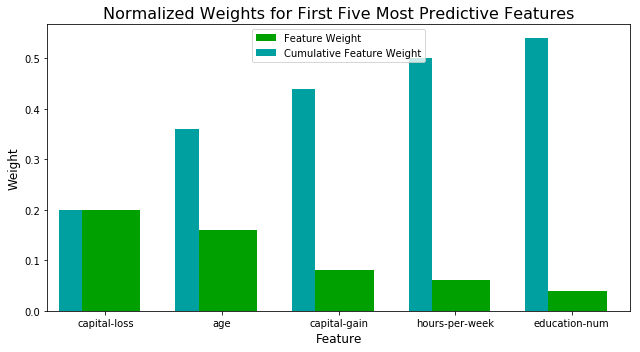

In [22]:
# Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier

# Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier().fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**

Overall I'd say I was fairly close in my predictions, however certainly not in ordering. I'm quite pleased to see my prediction of *capital-loss* and *capital-gain* to have been well founded, and age also turned out to be quite important. Two interesting findings are that *education-num* was much lower than I expected and *occupation* didn't even factor into the top five. I wonder if that's a result of the *occupation* feature being so sparse that the classifier never really considered it. I'm also somewhat surprised to see the *hours-per-week* feature being so important, though I do suppose it would indicate more demanding occupation (which should be better compensated) or harder working indivuduals, which does make sense. It may also serve as a sort of proxy to the occupation of the indivudual, similar to how I wrote that I anticipated *education-num* would be more predictive than *education-level*.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [25]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8704
F-score on testing data: 0.7492

Final Model trained on reduced data
------
Accuracy on testing data: 0.8428
F-score on testing data: 0.7004


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**

The final model, when only the top five most predictive features are used for training, performs slightly worse than the model trained on the full feature set: accuracy score decreases to 0.8428 from 0.8704, and F-score decreases to 0.7004 from 0.7492. However, the difference is not so severe as to entirely forsake the final model. If training and prediction speed were absolutely paramount, than I do think it would be worthwhile to use the smaller feature set, assuming the tradeoff between predictive and runtime performance is warranted. However, as the AdaBoost classifier trains on the full training dataset in only a fraction of a second, I don't suspect that this is a sufficient concern to desire the decreased predictive performance. If I were making an official recommendation to *CharityML*, I would suggest that they stick with the full feature set as it performs sufficiently better than the reduced feature set to justify the negligable increase in training and prediction time. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.